## Predicting Book Ratings on GoodReads using Regression Models

The objective of this section is to develop a linear regression model to forecast the "rating" value of books from GoodReads.

To achieve this goal, amongst other typical variables to rate literary books, I will use the "genres" and "awards" attributes, which were initially present in the dataset as strings embedded in individual lists. These two features contained up to 980 unique genres and 5831 unique awards.

After extracting, transforming, and reducing them into numerical variables in previous steps, I expect them to be sufficiently related to the target and that will enhance the robustness of the model.

The following steps will be undertaken in this process:

- Import the cleaned dataframe.
- Preprocess the variables to select and modify the appropriate ones for modeling.
- Develop the linear regression model and evaluate the performance metrics.
- Incorporate enhancements, if possible, such as using dimensionality reduction.
- Compare the outcomes with those of another regression model, Random Forest Regressor.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

### Import Dataframe

Importing clean dataframe
- Cleaning and wrangling were done in "1. goodreads_data_CLEANING_AND_WRANGLING.ipynb"

In [2]:
gr_data = pd.read_csv('./2. Clean_df/gr_data_CLEAN.csv')
gr_data = gr_data.drop(['Unnamed: 0'],axis=1)

In [3]:
display(gr_data.head(), gr_data.shape)

,title,series,author,description,language,pages,isbn,book_format,publish_year,first_publish_year,...,West Australian Young Readers' Book Award (WAYRBA) for Older Readers,West Australian Young Readers' Book Award (WAYRBA) for Younger Readers,William Allen White Children's Book Award,William C. Morris YA Debut Award Nominee,Women's Prize for Fiction Nominee,Women's Prize for Fiction Nominee for Longlist,World Fantasy Award Nominee for Best Novel,World Fantasy Award for Best Novel,Zilveren Griffel,الجائزة العالمية للرواية العربية (أي باف) / International Prize for Arabic Fiction (IPAF) Nominee
0,The Hunger Games,The Hunger Games,Suzanne Collins,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,English,200-300,9.78044E+12,Hardcover,2008,2008,...,1,0,0,0,0,0,0,0,0,0
1,Harry Potter and the Order of the Phoenix,Harry Potter,J.K. Rowling,There is a door at the end of a silent corrido...,English,700-800,9.78044E+12,Paperback,2004,2003,...,0,0,0,0,0,0,0,0,0,0
2,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,English,200-300,1E+13,Paperback,2006,1960,...,0,0,0,0,0,0,0,0,0,0
3,Pride and Prejudice,Single Book,Jane Austen,Alternate cover edition of ISBN 9780679783268S...,English,100-200,1E+13,Paperback,2000,2013,...,0,0,0,0,0,0,0,0,0,0
4,Twilight,The Twilight Saga,Stephenie Meyer,About three things I was absolutely positive.\...,English,400-500,9.78032E+12,Paperback,2006,2005,...,1,0,0,0,0,0,0,0,0,0


(48655, 862)

### Preprocessing data and features for modeling

#### Drop unnecesary columns

In [4]:
gr_data= gr_data.drop(['isbn','description'],axis=1)

In [5]:
gr_data.shape

(48655, 860)

#### NaN

In [6]:
gr_data.isna().sum().sum()

0

#### Types

In [7]:
gr_data.iloc[:, :18].dtypes

title                   object
series                  object
author                  object
language                object
pages                   object
book_format             object
publish_year             int64
first_publish_year       int64
publisher               object
liked_perc             float64
bbe_score              float64
bbe_votes              float64
log_num_ratings        float64
5_stars_num_ratings      int64
4_stars_num_ratings      int64
3_stars_num_ratings      int64
2_stars_num_ratings      int64
1_star_num_ratings       int64
dtype: object

In [8]:
numerical_columns = gr_data.select_dtypes(include=np.number).columns.tolist()
print(f"Numerical columns: {len(numerical_columns)}")

categorical_columns = gr_data.select_dtypes(include='object').columns.tolist()
print(f"Categorical columns: {len(categorical_columns)}")

Numerical columns: 853
Categorical columns: 7


#### Dealing with type of 'genres' and 'awards' multiple columns.
#### Converting to categorical

After extracting their names from their respective lists, I created two dataframes in which each unique genre and award was converted into a single column. If the original list for a book (row) contained that genre or award, the corresponding value in that record was assigned a 1; otherwise, it was assigned a 0.

The only exceptions are the columns that hold aggregated numbers for the binned awards in 'Unique Award (1)', 'Uncommon Award (2,3)', 'Singular Award (4-8)', and 'Frequently Awarded Literary Prizes (9-15)'. In order to reduce the thousands of unique awards, I grouped them according to their frequency.

Since the binned award columns should be treated as numerical data and the 1-0 column values as categorical, I will import those dataframes to generate a list with all those columns names (more than 800) and then assign the appropriate data types in the original dataframe.

Kernels (in '0. Drafts' folder):

- 1.1 goodreads_genres_REDUCTION.ipynb
- 1.2 goodreads_genres_NEWDF.ipynb
- 1.3 goodreads_awards_NEWDF.ipynb

In [9]:
# Importing dataframes
award_df = pd.read_csv('./0. Drafts/award_df.csv')
award_df = award_df.drop(['Unnamed: 0'],axis=1)
award_df = award_df.drop(['index_gr_data'],axis=1)

genres_df = pd.read_csv('./0. Drafts/genres_clean_dataset.csv')
genres_df = genres_df.drop(['Unnamed: 0'],axis=1)
genres_df = genres_df.drop(['index_gr_data'],axis=1)

In [10]:
# As all values in genre_df are 0 or 1, I'm appending them into binary_columns list
binary_columns = [column for column in genres_df.columns]
len(binary_columns)

609

In [11]:
# Extracting binary column names and appending to previous list.
for column in award_df.columns:
    unique_values = award_df[column].unique()
    if set(unique_values) != set([0, 1]):
        continue
        #non_binary_columns.append(column)
    elif set(unique_values) == set([0, 1]):
        binary_columns.append(column)

In [12]:
# New length
len(binary_columns)

844

In [13]:
# Loop through columns names in gr_data; if listed in binary_columns converted to 'object' type
for column in gr_data.columns:
    if column in binary_columns:
        gr_data[column] = gr_data[column].astype('object')

In [14]:
numerical_columns = gr_data.select_dtypes(include=np.number).columns.tolist()
print(f"Numerical columns: {len(numerical_columns)}")

categorical_columns = gr_data.select_dtypes(include='object').columns.tolist()
print(f"Categorical columns: {len(categorical_columns)}")

Numerical columns: 16
Categorical columns: 844


#### Numerical Data

In [15]:
numerical = gr_data.select_dtypes(include=np.number)
numerical.shape
#categorical = gr_data.select_dtypes(include=['object'])

(48655, 16)

- Correlation amongst features: correlation matrix

In [16]:
# Correlation matrix for numerical values (854 columns)
corr_matrix = numerical.corr()

In [18]:
# Indices of non-NaN values in the correlation matrix
indices = [(row, col) for row in corr_matrix.index for col in corr_matrix.columns if not pd.isna(corr_matrix.loc[row, col])]

# New df with the row and column's names, and correlation number
df = pd.DataFrame([(idx[0], idx[1], corr_matrix.loc[idx]) for idx in indices if (corr_matrix.loc[idx] > 0.6 or corr_matrix.loc[idx] < -0.6) and idx[0] != idx[1]], columns=['row name', 'col name', 'corr number'])

# Drop duplicate rows where row name is greater than col name (diagonal)
df = df[df['row name'] < df['col name']]

# Sort df by the correlation number in descending order
df = df.sort_values(by='corr number', ascending=False)

# Sorted df
display(df, len(df))


,row name,col name,corr number
11,3_stars_num_ratings,4_stars_num_ratings,0.957836
16,2_stars_num_ratings,3_stars_num_ratings,0.956072
0,bbe_score,bbe_votes,0.939596
21,1_star_num_ratings,2_stars_num_ratings,0.933824
6,4_stars_num_ratings,5_stars_num_ratings,0.931859
15,2_stars_num_ratings,4_stars_num_ratings,0.856281
10,3_stars_num_ratings,5_stars_num_ratings,0.831870
20,1_star_num_ratings,3_stars_num_ratings,0.820076
14,2_stars_num_ratings,5_stars_num_ratings,0.726403
19,1_star_num_ratings,4_stars_num_ratings,0.711987


11

 - Check counts from paired highly-correlated variables to choose which one to eliminate

In [19]:
#display(numerical['Hugo Award for Best Novel '].value_counts(),numerical['hugo awards'].value_counts())

In [20]:
#display(numerical['love inspired'].value_counts(),numerical['love inspired historical'].value_counts())

In [21]:
# High correlated variables to drop
high_correlated = ['2_stars_num_ratings','3_stars_num_ratings','4_stars_num_ratings',
                   'bbe_votes']

In [22]:
# High correlated variables to drop
# high_correlated = ['2_stars_num_ratings','3_stars_num_ratings','4_stars_num_ratings',
#                   'bbe_votes','hugo awards','booze','love inspired historical']

In [23]:
numerical.shape

(48655, 16)

In [24]:
# Drop high correlated variables
numerical = numerical.drop(high_correlated, axis=1)

# New shape
numerical.shape

(48655, 12)

#### Categorical Data

In [25]:
categorical = gr_data.select_dtypes(include=['object'])
categorical.shape

(48655, 844)

In [26]:
# Unique values
#for col in categorical.columns:
#    print(f"Unique values for {col}: {categorical[col].nunique()}")

- Reducing unique values

Author

In [27]:
categorical['author']

0        Suzanne Collins
1           J.K. Rowling
2             Harper Lee
3            Jane Austen
4        Stephenie Meyer
              ...       
48650      Sherry Gammon
48651      Emma Michaels
48652     Kim Richardson
48653        Tom Pollack
48654       Misty Moncur
Name: author, Length: 48655, dtype: object

To categorize the authors, I will group them into 'Top 1000', 'Top 1001-10000', and 'General Authors'. This grouping will be based on the average 'rating' of authors who have published more than one book.

To ensure a fair average, I will exclude authors who have only published one book and received a rating of 5 from the calculation."

In [28]:
# Count the number of books for each author
author_counts = gr_data['author'].value_counts()

# Filter to only include authors with a count greater than 1
filtered_authors = author_counts[author_counts > 1].index

# Filter in the original df to only include titles with authors in the filtered authors
filtered_gr_data = gr_data[gr_data['author'].isin(filtered_authors)]

# Group by author and calculate the mean rating for each author
author_avg_rating = filtered_gr_data.groupby('author')['rating'].mean()

# Sort in descending order of average rating and select the top 1000 authors
top_1000_most_rated_authors = author_avg_rating.sort_values(ascending=False).head(1000)

# Convert to a dataframe
top_1000_most_rated_authors_df = top_1000_most_rated_authors.to_frame().reset_index()

display(len(top_1000_most_rated_authors_df))

top_1000_most_rated_authors_df.head(30)

1000

,author,rating
0,James Goodman,5.00
1,"Doug ""Hollywood"" Davis",5.00
2,Natasha Lukin,5.00
3,Rita Pam Tarachi,5.00
4,Granthana Sinha,5.00
5,Nadine May,5.00
6,Bernard Cenney,5.00
7,Luke A.M. Brown,5.00
8,Susan Davis,5.00
9,Rodolfo Martin Vitangcol,5.00


In [29]:
# Second group, same process

author_counts = gr_data['author'].value_counts()
filtered_authors = author_counts[author_counts > 1].index
filtered_gr_data = gr_data[gr_data['author'].isin(filtered_authors)]
author_avg_rating = filtered_gr_data.groupby('author')['rating'].mean()
top_1001_to_10000_most_rated_authors = author_avg_rating.sort_values(ascending=False).iloc[1000:10000]
top_1001_to_10000_most_rated_authors_df = top_1001_to_10000_most_rated_authors.to_frame().reset_index()

display(len(top_1001_to_10000_most_rated_authors_df))
top_1001_to_10000_most_rated_authors_df.head(10)


6180

,author,rating
0,Adrienne Rich,4.276667
1,E.F. Benson,4.276667
2,Lexie Xu,4.276667
3,Anna Zaires,4.276667
4,Mandi Beck,4.276667
5,Arnold Lobel,4.276667
6,Lois Walfrid Johnson,4.276667
7,Amy Clipston,4.276667
8,J.M. Darhower,4.276000
9,Mike Mignola,4.276000


In [30]:
# Third group, same process

author_counts = gr_data['author'].value_counts()
single_authors = author_counts[author_counts == 1].index
general_authors_data = gr_data[~gr_data['author'].isin(top_1000_most_rated_authors.index) & ~gr_data['author'].isin(top_1000_most_rated_authors.index) & gr_data['author'].isin(single_authors)]
general_authors_avg_rating = general_authors_data.groupby('author')['rating'].mean()
general_authors_avg_rating_df = general_authors_avg_rating.to_frame().reset_index()

display(len(general_authors_avg_rating_df))
general_authors_avg_rating_df.head(10)

14540

,author,rating
0,50 Cent,4.15
1,A. Bates,3.54
2,A. Cort Sinnes,4.50
3,A. Helwa,4.63
4,A. Merritt,3.33
5,A. Roger Ekirch,3.68
6,A. Scott Berg,4.00
7,A. Teeuw,4.06
8,A. Ubaidillah Alias,3.94
9,A. White,4.93


In [31]:
# Check result

# Unique authors in the original dataframe
num_unique_authors = len(gr_data['author'].unique())

# Unique authors in new authors dataframes
num_top_1000_authors = len(top_1000_most_rated_authors_df)
num_top_1001_to_10000_authors = len(top_1001_to_10000_most_rated_authors_df)
num_general_authors = len(general_authors_avg_rating_df)

# Check if the sum of the number of new dataframes is equal to unique authors in the original dataframe
if num_top_1000_authors + num_top_1001_to_10000_authors + num_general_authors == num_unique_authors:
    print("The number of unique authors in the three new dataframes is equal to the number of unique authors in the original gr_data dataframe.")
else:
    print("The number of unique authors in the three new dataframes is not equal to the number of unique authors in the original gr_data dataframe.")

The number of unique authors in the three new dataframes is equal to the number of unique authors in the original gr_data dataframe.


In [32]:
# Replace the author values in categorical['author'] with the appropriate category
categorical['author'] = np.where(categorical['author'].isin(top_1000_most_rated_authors_df['author']), 'top_1000_most_rated_authors',
                        np.where(categorical['author'].isin(top_1001_to_10000_most_rated_authors_df['author']), 'top_1001_to_10000_most_rated_authors',
                        np.where(categorical['author'].isin(general_authors_avg_rating_df['author']), 'general_authors',
                                 categorical['author'])))

categorical.head(10)

,title,series,author,language,pages,book_format,publisher,fantasy,science fiction,dystopia,...,West Australian Young Readers' Book Award (WAYRBA) for Older Readers,West Australian Young Readers' Book Award (WAYRBA) for Younger Readers,William Allen White Children's Book Award,William C. Morris YA Debut Award Nominee,Women's Prize for Fiction Nominee,Women's Prize for Fiction Nominee for Longlist,World Fantasy Award Nominee for Best Novel,World Fantasy Award for Best Novel,Zilveren Griffel,الجائزة العالمية للرواية العربية (أي باف) / International Prize for Arabic Fiction (IPAF) Nominee
0,The Hunger Games,The Hunger Games,top_1001_to_10000_most_rated_authors,English,200-300,Hardcover,Top Publishers,1,1,1,...,1,0,0,0,0,0,0,0,0,0
1,Harry Potter and the Order of the Phoenix,Harry Potter,top_1000_most_rated_authors,English,700-800,Paperback,Top Publishers,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,To Kill a Mockingbird,To Kill a Mockingbird,top_1001_to_10000_most_rated_authors,English,200-300,Paperback,Top Publishers,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Pride and Prejudice,Single Book,top_1001_to_10000_most_rated_authors,English,100-200,Paperback,Top Publishers,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Twilight,The Twilight Saga,top_1001_to_10000_most_rated_authors,English,400-500,Paperback,Top Publishers,1,1,0,...,1,0,0,0,0,0,0,0,0,0
5,The Book Thief,Single Book,top_1001_to_10000_most_rated_authors,English,400-500,Hardcover,Top Publishers,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Animal Farm,Single Book,top_1001_to_10000_most_rated_authors,English,<100,Paperback,Top Publishers,1,1,1,...,0,0,0,0,0,0,0,0,0,0
7,The Chronicles of Narnia,Single Book,top_1001_to_10000_most_rated_authors,English,600-700,Paperback,Top Publishers,1,1,0,...,0,0,0,0,0,0,0,0,0,0
8,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,The Lord of the Rings-3,top_1001_to_10000_most_rated_authors,English,900-1000,Paperback,Top Publishers,1,1,0,...,0,0,0,0,0,0,0,0,0,0
9,Gone with the Wind,Single Book,top_1000_most_rated_authors,English,900-1000,Paperback,Top Publishers,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
categorical['author'].unique()

array(['top_1001_to_10000_most_rated_authors',
       'top_1000_most_rated_authors', 'general_authors'], dtype=object)

Series

In [34]:
categorical['series'].nunique()

4405

To group the series, I will create two categories: 'Top 500 rated series' and 'Other Series'. For books not included in any literary saga, I will keep them under the existing 'Single Books' category. The grouping will be based on the average 'rating' for each series, using a similar process to the previous grouping method.

In [35]:
# Filter the original dataframe to only include titles that are not 'Single Book'
series_data = gr_data[gr_data['series'] != 'Single Book']

# Group by series and calculate the mean rating for each series
series_avg_rating = series_data.groupby('series')['rating'].mean()

# Sort in descending order based on the average rating and select the top 500 series
top_500_most_rated_series = series_avg_rating.sort_values(ascending=False).head(500)

# Filter the original dataframe to only include titles with series not in the top rated series lists or with empty series
other_series_data = series_data[~series_data['series'].isin(top_500_most_rated_series.index) & (series_data['series'] != '')]

# Group by series and calculate the mean rating for each series
other_series_avg_rating = other_series_data.groupby('series')['rating'].mean()

# Convert to a dataframe
top_500_most_rated_series_df = top_500_most_rated_series.to_frame().reset_index()
other_series_avg_rating_df = other_series_avg_rating.to_frame().reset_index()


In [36]:
# Replace series values in categorical['series'] with the appropriate category
categorical['series'] = np.where(categorical['series'] == 'Single Book', 'Single Book',
                    np.where(categorical['series'].isin(top_500_most_rated_series_df['series']), 'Top 500 rated series',
                    np.where(categorical['series'].isin(other_series_avg_rating_df['series']), 'Other series',
                    categorical['series'])))


In [37]:
categorical['series'].unique()

array(['Other series', 'Top 500 rated series', 'Single Book'],
      dtype=object)

Title

In [38]:
categorical['title'].nunique()

46328

As there are a lot of unique authors, I have decided to drop that column

In [39]:
categorical = categorical.drop(['title'],axis=1)

Language

Here, I will identify the 5 most frequently published languages and keep their names. For all other languages, I will group them into a single category named 'Other languages'

In [40]:
categorical['language'].value_counts()

English                                  43415
Arabic                                     894
Spanish                                    632
French                                     562
German                                     501
                                         ...  
Iranian (Other)                              1
Aromanian; Arumanian; Macedo-Romanian        1
gu                                           1
Faroese                                      1
Afrikaans                                    1
Name: language, Length: 92, dtype: int64

In [41]:
# Count the unique values in the 'language' column
language_counts = categorical['language'].value_counts()

# Top 5 most common languages
top_languages = language_counts.index[:5]
top_languages

Index(['English', 'Arabic', 'Spanish', 'French', 'German'], dtype='object')

In [42]:
# Replace all the other languages with 'Other languages'
categorical.loc[~categorical['language'].isin(top_languages), 'language'] = 'Other languages'

In [43]:
categorical['language'].unique()

array(['English', 'French', 'German', 'Other languages', 'Arabic',
       'Spanish'], dtype=object)

In [44]:
categorical['language'].nunique()

6

In [78]:
# Unique values
# for col in categorical.columns:
#    print(f"Unique values for {col}: {categorical[col].nunique()}")

#### Concatenate numerical and categorical processed data

In [46]:
gr_data_for_modelling = pd.concat([categorical,numerical],axis=1)

In [47]:
display(gr_data_for_modelling.head(3),gr_data_for_modelling.shape)

,series,author,language,pages,book_format,publisher,fantasy,science fiction,dystopia,young adult,...,liked_perc,bbe_score,log_num_ratings,5_stars_num_ratings,1_star_num_ratings,rating,Unique Award (1),"Uncommon Award (2,3)",Singular Award (4-8),Frequently Awarded Literary Prizes (9-15)
0,Other series,top_1001_to_10000_most_rated_authors,English,200-300,Hardcover,Top Publishers,1,1,1,1,...,96.0,6.476225,6.804602,3444695,93557,4.33,4,5,3,15
1,Top 500 rated series,top_1000_most_rated_authors,English,700-800,Paperback,Top Publishers,1,1,0,1,...,98.0,6.420324,6.399262,1593642,14526,4.50,2,0,1,3
2,Other series,top_1001_to_10000_most_rated_authors,English,200-300,Paperback,Top Publishers,0,0,0,1,...,95.0,6.355911,6.653316,2363896,80794,4.28,0,0,0,2


(48655, 855)

In [48]:
# NaN values
gr_data_for_modelling.isna().sum().sum()

0

#### Saving data processed for modelling

In [49]:
gr_data_for_modelling.to_csv('./2. Clean_df/gr_data_MODELLING.csv')

## Linear Regression Model

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

#import scipy.stats as stats

In [51]:
gr_data = pd.read_csv('./2. Clean_df/gr_data_MODELLING.csv')
gr_data = gr_data.drop(['Unnamed: 0'],axis=1)
gr_data.shape

(48655, 855)

In [52]:
gr_data.head()

,series,author,language,pages,book_format,publisher,fantasy,science fiction,dystopia,young adult,...,liked_perc,bbe_score,log_num_ratings,5_stars_num_ratings,1_star_num_ratings,rating,Unique Award (1),"Uncommon Award (2,3)",Singular Award (4-8),Frequently Awarded Literary Prizes (9-15)
0,Other series,top_1001_to_10000_most_rated_authors,English,200-300,Hardcover,Top Publishers,1,1,1,1,...,96.0,6.476225,6.804602,3444695,93557,4.33,4,5,3,15
1,Top 500 rated series,top_1000_most_rated_authors,English,700-800,Paperback,Top Publishers,1,1,0,1,...,98.0,6.420324,6.399262,1593642,14526,4.50,2,0,1,3
2,Other series,top_1001_to_10000_most_rated_authors,English,200-300,Paperback,Top Publishers,0,0,0,1,...,95.0,6.355911,6.653316,2363896,80794,4.28,0,0,0,2
3,Single Book,top_1001_to_10000_most_rated_authors,English,100-200,Paperback,Top Publishers,0,0,0,0,...,94.0,6.297348,6.476867,1617567,76770,4.26,0,0,0,0
4,Other series,top_1001_to_10000_most_rated_authors,English,400-500,Paperback,Top Publishers,1,1,0,1,...,78.0,6.164189,6.695877,1751460,548674,3.60,3,5,4,6


#### X-y split

In [53]:
# Target = 'rating'
y = gr_data['rating']
X = gr_data.drop(['rating'],axis=1)

#### Train-Test Split

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

#### Split both Train and Test into numerical and categoricals

In [56]:
# X_train
X_train_num = X_train.select_dtypes(include=np.number)
X_train_cat = X_train.select_dtypes(include=['object'])

# X_test
X_test_num = X_test.select_dtypes(include=np.number)
X_test_cat = X_test.select_dtypes(include=['object'])

#### Numerical Transformations

- Fit only with numericals_train

In [57]:
scaler = StandardScaler().fit(X_train_num)

- Transform both numericals_train and numericals_test

In [58]:
X_train_num_scaled = scaler.transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

In [59]:
# Convert X_train_num_scaled and X_test_num_scaled to dataframes
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns)

#### Categorical Encoding

Fit only with categoricals_train

In [60]:
encoder = OneHotEncoder().fit(X_train_cat)

Encode both categoricals_train and numericals_test

In [61]:
X_train_cat_encoded = encoder.transform(X_train_cat)
X_test_cat_encoded = encoder.transform(X_test_cat)

In [62]:
# Convert X_train_cat_encoded and X_test_cat_encoded to dataframes
X_train_cat_encoded_df = pd.DataFrame(X_train_cat_encoded.toarray(), columns=encoder.get_feature_names_out())
X_test_cat_encoded_df = pd.DataFrame(X_test_cat_encoded.toarray(), columns=encoder.get_feature_names_out())

#### Combine numericals_train and categoricals_train into train_processed

In [63]:
train_processed = pd.concat([X_train_num_scaled_df, X_train_cat_encoded_df], axis=1)

#### Combine numericals_test and categoricals_test into test_processed

In [64]:
test_processed = pd.concat([X_test_num_scaled_df, X_test_cat_encoded_df], axis=1)

#### Define Linear Regression Model

- Fit model on train_processed

In [65]:
lr = LinearRegression().fit(train_processed, y_train)

In [66]:
# Predictions on training data
y_train_pred = lr.predict(train_processed)

print("First 5 predictions on the training data:", y_train_pred[:5])

# Evaluation metrics
r2 = r2_score(y_train, y_train_pred)
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
mse = mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)

print("\nR-squared score on the training data:", round(r2, 2))
print("Root mean squared error on the training data:", round(rmse, 2))
print("Mean squared error on the training data:", round(mse, 2))
print("Mean absolute error on the training data:", round(mae, 2))

First 5 predictions on the training data: [3.73948669 4.16273499 3.79444885 4.09135437 3.90409851]

R-squared score on the training data: 0.45
Root mean squared error on the training data: 0.26
Mean squared error on the training data: 0.07
Mean absolute error on the training data: 0.16


#### Predictions on test_processed and scores

In [80]:
# Predictions on test data
y_test_pred = lr.predict(test_processed)

print("Actual data:\n", y_test[:6])
print("\nPredictions on the TEST data:", y_test_pred[:6])

# Evaluation metrics on test data
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("\nR-squared score on the test data:", round(r2_test, 2))
print("Root mean squared error on the test data:", round(rmse_test, 2))
print("Mean squared error on the test data:", round(mse_test, 2))
print("Mean absolute error on the test data:", round(mae_test, 2))

Actual data:
 13219    4.05
28726    4.00
46900    3.86
13985    4.51
40148    4.10
27223    3.97
Name: rating, dtype: float64

Predictions on the TEST data: [4.00071716 4.00016785 3.89833069 4.48484802 3.92564392 3.77653503]

R-squared score on the test data: 0.42
Root mean squared error on the test data: 0.27
Mean squared error on the test data: 0.07
Mean absolute error on the test data: 0.17


In [68]:
gr_data['rating'].describe()

count    48655.000000
mean         4.015514
std          0.347446
min          0.000000
25%          3.820000
50%          4.020000
75%          4.220000
max          5.000000
Name: rating, dtype: float64

After trying to use 'genres' and 'awards' (binary values) features both as numerical or categorical, the model is not performing well on the test data in any case:

An R-squared score of 0.42 indicates that the model explains 42% of the variance in the target variable.

The root mean squared error (RMSE) on the test data is 0.27 ('rating' std = 0.34), which means that on average, the model's predictions are off by 0.27 units from the actual values.

The mean squared error (MSE) on the test data is 0.07, which is the average squared difference between the predicted and actual values.

The mean absolute error (MAE) on the test data is 0.17, which is the average absolute difference between the predicted and actual values.

#### Dimensionality Reduction: PCA and RFE

Considering that there are no large differences between the prediction scores of train and test data and variance of results for different subsets it's low, this model seems not to be overfitted. However, I'm going to check anyways if dimensionality reduction helps improving this scores.

To do so, I'm going to apply PCA and RFE.

- Principal Component Analysis PCA

Despite the potential loss of interpretability (since the principal components are linear combinations of the original features) and that PCA assumes a linear relationship between the features and the target (which seems weak at the moment after the scores of my model), I'm going to use PCA as it can reveal patterns and relationships in the data that may not be apparent in the original feature space.

In [69]:
from sklearn.decomposition import PCA

# Fit PCA on training data
pca = PCA() #n_components=100
pca.fit(train_processed)

#pca.explained_variance_ratio_.round(2)

PCA()

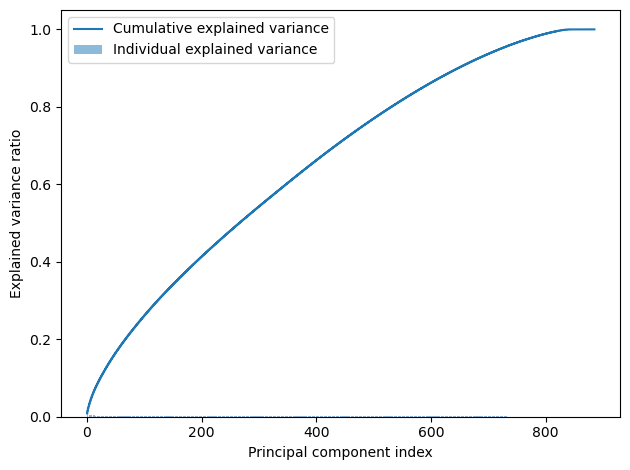

In [70]:
# Get the explained variance ratios
exp_var_pca = pca.explained_variance_ratio_

# Calculate the cumulative sum of variance explained
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#cum_sum_eigenvalues

# Plot the cumulative explained variance vs number of components
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, 
        alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, 
         where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

As shown in the graph, we can see that the features selected to predict the target variable have a very weak ability to capture the variance in the original data. Therefore, it may be difficult to improve the regression model just by reducing dimensionality.

In [71]:
gr_data.shape

(48655, 855)

In [72]:
pca.explained_variance_ratio_[:650].sum()

0.9011793924892567

Number of dimensions: 650 (Variance explained 0.90)

In [73]:
# Fit PCA on training data
pca = PCA(0.90)
pca.fit(train_processed)

PCA(n_components=0.9)

In [74]:
# Transform training and test data
X_train_pca = pca.transform(train_processed)
X_test_pca = pca.transform(test_processed)

Linear Regression with PCA

In [75]:
# Fit linear regression on transformed data
lr_pca = LinearRegression().fit(X_train_pca, y_train)

# Predict on test set
y_pred_pca = lr_pca.predict(X_test_pca)

# Calculate R-squared score
r2_pca = r2_score(y_test, y_pred_pca)
print("R-squared score (PCA transformed):", r2_pca)

R-squared score (PCA transformed): 0.3205262322266471


In [76]:
#plt.scatter(X_train_pca[:,0],X_train_pca[:,1], c = y_train)

The R2 score of the linear regression model decreased (-0.1)after applying PCA, indicating that the PCA transformation did not improve the model's ability to predict the target variable.

#### Recursive Feature Elimination RFE

RFE helps to identify the most important features related to the target and it and can improve the accuracy of the model without sacrificing too much predictive power or information. As in each iteration removes the less ranked features in rfe.ranking_ I'm going to check if this type of reduction leads my regression model to better scores.

In [82]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE

# Range of values for n_features_to_select
n_features_to_selects = range(200, 601, 100)

# Empty list to store the results
results = []

for n_features_to_select in n_features_to_selects:
    # RFE on the training set
    lm_rfe = LinearRegression()
    rfe = RFE(lm_rfe, n_features_to_select=n_features_to_select, verbose=False)
    rfe.fit(train_processed, y_train)

    # Top features from the test set
    X_train_rfe = rfe.transform(train_processed)
    X_test_rfe = rfe.transform(test_processed)

    # Train the model on the selected features
    lm_rfe.fit(X_train_rfe, y_train)

    # predict the ratings for both training and test sets
    y_train_pred = lm_rfe.predict(X_train_rfe)
    y_test_pred = lm_rfe.predict(X_test_rfe)

    # calculate the R2 score for both sets
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Append the results to the list
    results.append((n_features_to_select, r2_train, r2_test))

# New dataFrame to store the results
df_results = pd.DataFrame(results, columns=['n_features_to_select', 'R2 Score (Train)', 'R2 Score (Test)'])
df_results.set_index('n_features_to_select', inplace=True)

# Get summary statistics of the 'rating' column
rating_summary = gr_data['rating'].describe()

# Format the summary statistics string
summary_str = f"Target metrics:\n{rating_summary.to_string()}"
summary_str += "\n\n"

# Print the results DataFrame and the summary statistics
print(summary_str)
display(df_results)

Target metrics:
count    48655.000000
mean         4.015514
std          0.347446
min          0.000000
25%          3.820000
50%          4.020000
75%          4.220000
max          5.000000




,R2 Score (Train),R2 Score (Test)
n_features_to_select,,
200,0.439327,0.421597
300,0.442724,0.420984
400,0.444348,0.421672
500,0.445382,0.421402
600,0.445978,0.421274


In [84]:
#rfe.ranking_

It seems like the RFE (Recursive Feature Elimination) approach was able to achieve a similar R2 score as the linear regression model, while only using 600 features compared to the original LR model's 855 features. This suggests that the RFE approach was able to identify the most important features for predicting the target variable and remove the irrelevant ones.

On the other hand, the PCA approach performed much worse with an R2 score of -0.12, even though it operated with 650 features. This may indicate that PCA was not able to capture enough variance in the data and may have discarded important information during dimensionality reduction.

## Alternative model: Random Forest Regressor

As dimensionality reduction has not improved the scores of my linear regression model, I'm going to use a Random Forest Regressor (RFR) to predict the 'rating' and check if this model it's more sensitive to more complex relationships between the features and the target.

Linear regression and random forest are two popular algorithms used in machine learning for regression tasks. Here are some pros and cons of each algorithm:

Linear Regression:
Pros:

Simplicity: Linear regression is a simple and easy-to-understand algorithm, which makes it a good choice for simple problems.
Speed: Linear regression is a fast algorithm that can handle large datasets with many features.
Interpretability: The coefficients of a linear regression model can be easily interpreted as the effect of each feature on the target variable.
Cons:

Linearity assumption: Linear regression assumes that the relationship between the features and the target variable is linear, which may not be true in all cases.
Sensitivity to outliers: Linear regression is sensitive to outliers, which can have a large effect on the estimated coefficients.
Limited flexibility: Linear regression is limited to linear relationships, which may not capture complex relationships in the data.


Random Forest:
Pros:

Non-linearity: Random forest can capture non-linear relationships between the features and the target variable.
Robustness: Random forest is robust to outliers and noise in the data, since it averages the predictions of multiple trees.
Flexibility: Random forest can handle a wide range of data types, including categorical and continuous variables.
Cons:

Complexity: Random forest can be a complex algorithm to understand and tune, especially when dealing with large datasets.
Black-box model: Random forest can be difficult to interpret, since it involves multiple decision trees.
Overfitting: Random forest can overfit the training data if the number of trees or the depth of the trees is too high.
Overall, the choice between linear regression and random forest depends on the specific problem and data at hand. Linear regression is a good choice for simple problems with linear relationships, while random forest is more flexible and can handle more complex relationships, but may require more tuning and can be harder to interpret.

##### Random Forest Regressor

In [85]:
from sklearn.ensemble import RandomForestRegressor

# Range of values for max_depth
max_depths = range(5, 51, 5)

# Empty list to store the results
results = []

for max_depth in max_depths:
    # Model
    rf = RandomForestRegressor(max_depth=max_depth, min_samples_split=200, min_samples_leaf=200)
    # Fit
    rf.fit(train_processed, y_train)
    # Predictions on the test data
    y_pred = rf.predict(test_processed)

    # Evaluation metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Append the results to the list
    results.append((max_depth, r2, rmse, mse, mae))

# New DataFrame to store the results
df_results = pd.DataFrame(results, columns=['max_depth', 'R2 Score', 'RMSE', 'MSE', 'MAE'])
df_results.set_index('max_depth', inplace=True)

# Get summary statistics of the 'rating' column
rating_summary = gr_data['rating'].describe()

# Format the summary statistics string
summary_str = f"Target metrics:\n{rating_summary.to_string()}"
summary_str += "\n\n"

# Print the results DataFrame and the summary statistics
print(summary_str)
display(df_results)


Target metrics:
count    48655.000000
mean         4.015514
std          0.347446
min          0.000000
25%          3.820000
50%          4.020000
75%          4.220000
max          5.000000




,R2 Score,RMSE,MSE,MAE
max_depth,,,,
5,0.619288,0.216456,0.046853,0.123997
10,0.635481,0.211803,0.044860,0.117658
15,0.636279,0.211571,0.044762,0.117795
20,0.634242,0.212163,0.045013,0.117794
25,0.634487,0.212092,0.044983,0.117712
30,0.635357,0.211839,0.044876,0.117912
35,0.635162,0.211896,0.044900,0.117765
40,0.635680,0.211745,0.044836,0.117746
45,0.635956,0.211665,0.044802,0.117772


The initial results of using RFR with a range of max_depth (5-50) show a significant improvement in the R2 score. The highest score achieved within this range was with max_depth = 15, which had a score of 0.636 (+0.21 compared to the LR model).

Additionally, RFR outperforms LR in terms of RMSE (-0.06), MSE (-0.03), and MAE (-0.06).

Next, I will explore the effect of larger max_depth values on the performance of the RFR model.

In [86]:
from sklearn.ensemble import RandomForestRegressor
# Range of values for max_depth
max_depths = range(50, 1001, 100)

# Empty list to store the results
results = []

for max_depth in max_depths:
    # Model
    rf = RandomForestRegressor(max_depth=max_depth, min_samples_split=200, min_samples_leaf=200)
    # Fit
    rf.fit(train_processed, y_train)
    # Predictions on the test data
    y_pred = rf.predict(test_processed)

    # Evaluation metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Append the results to the list
    results.append((max_depth, r2, rmse, mse, mae))

# New dataFrame to store the results
df_results = pd.DataFrame(results, columns=['max_depth', 'R2 Score', 'RMSE', 'MSE', 'MAE'])
df_results.set_index('max_depth', inplace=True)

display(df_results)
display("Target metrics: mean 4.015 / std 0.347 / min 0.00 / 25% 3.82 / 50% 4.02 / 75% 4.22 / max 5.00",)

,R2 Score,RMSE,MSE,MAE
max_depth,,,,
50,0.635116,0.211909,0.044905,0.117616
150,0.635553,0.211782,0.044852,0.117948
250,0.635504,0.211796,0.044858,0.117730
350,0.636942,0.211378,0.044681,0.117684
450,0.636564,0.211488,0.044727,0.117716
550,0.635411,0.211823,0.044869,0.117740
650,0.635741,0.211727,0.044828,0.117536
750,0.635922,0.211675,0.044806,0.117607
850,0.636114,0.211619,0.044783,0.117649


'Target metrics: mean 4.015 / std 0.347 / min 0.00 / 25% 3.82 / 50% 4.02 / 75% 4.22 / max 5.00'

Larger depths for RFR predictions have not achieved significant differences from previous ones. In this new range (50-950), the greatest R2 score for test predictions is max_depth=350, with a score only +0.0007 larger than the one obtained previously by max_depth=15. The other metrics also do not show any important differences.

# Conclusion

Amongst the typical features to assess literary books, my personal approach of using the great amount of unique genres and awards (listed in GoodReads dataset) as key predictors has not yield the expected results expected when applied to regression models.

Although Random Forest Regressor (RFR) has achieved to explain the 63% of the variability in the target, which is moderately acceptable, it's still difficult to assess the non-linear and more complex relationship between these features and the 'rating'. A relationship that may not have been captured by the previous Linear Regression (LR).

In fact, LR model only got an R2 score of 0.42, below the acceptable threshold, regardless of whether or not recursive feature elimination was applied. PCA got even worse results, yet it also provided evidence of the features' inadequate capacity to account for the variance.

In summary, the use of so many features as predictors may not have facilitated the creation of a more robust regression model. Nonetheless, the RFR metrics indicate that this model is far from useless and has considerable room for improvement.